In [ ]:
# FOR THE ACTUAL CODE USE THE .py FILE, THIS IS JUST A SANDBOX FILE

In [1]:
# Do imports in jupyter

import sys  
sys.path.insert(1, r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\Model srcs\SimCLR-OADS")
sys.path.insert(1, r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\Model srcs\SimCLR-OADS\models")

In [2]:
import os
import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import tqdm
from scipy.stats import zscore
import pandas as pd
# YO::
from OADSDataset import OADSDataset
from models.resnet_simclr import ResNetSimCLR
from models.alexnet_simclr import AlexNetSimCLR

############################################ Params


original_sampling_rate = 1024  # Hz
downsampling_factor = 4

# Choose subjects to run on
subjects = range(5, 36)
######################## Set paths, number of workers/cores, GPU/CPU access

gpu_name = 'cuda:0'
device = torch.device(gpu_name if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')
torch.cuda.empty_cache()

batch_size = 32  # 512 # 512

# TODO: change when running on DAS4
n_workers = 1

# YO: what is this?
######################## Set number of output channels of the models (corresponds to number of classes)
#output_channels = 19

# Output dir for processed data
output_dir = r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\EEG data\outputs"

# Directory with files
eeg_dir = r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\EEG data\oads_eeg_rsvp"

dataset_root_dir = r"C:\Users\YO\OneDrive - UvA\ARW"
# dataset_csv_file = r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\Practice\cropped_images\png\filenames.csv"

# TODO: save this info
checkpoint_path = (r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\Model srcs\checkpoints\runs resnet18\Jan29_19-06-56_node436\checkpoint_0200.pth.tar")

model_type = 'resnet18'

out_dim = 128


Running on device: cuda:0


In [9]:
# Define funcs

def record_activations(data_loader, model, return_nodes, device):
    """Extract features for all layers and all images/batches and return a dictionary"""

    model = create_feature_extractor(model, return_nodes)
    model.eval()  # Set the feature extractor to evaluation mode

    all_activations = {}

    # Iterate through the data loader
    img_idx = 0
    for batch_idx, inputs in enumerate(data_loader):
        inputs = inputs.to(device)
        with torch.no_grad():
            activations = model(inputs)

            for layer_name, activation_tensor in activations.items():
                if layer_name not in all_activations:
                    all_activations[layer_name] = {}

                #all_activations[layer_name][batch_idx] = activation_tensor.detach().cpu().numpy()
                # iterate over the batch
                for img in activation_tensor.detach().cpu().numpy():
                    all_activations[layer_name][img_idx] = img
                    img_idx += 1
    return all_activations


def flatten_layer(layer):
    """flatten a layer of a dictionary returned from record_activations"""
    flattened_arrays = []

    for key, arr in layer.items():
        # Flatten the ndarray
        flattened_arr = arr.flatten()
        # Append the flattened array to the list
        flattened_arrays.append(flattened_arr)

    # Convert the list of flattened arrays into a 2D array
    # Stack the flattened arrays vertically
    x = np.vstack(flattened_arrays)
    return x


def format_filenames(filename_list):
    """Make necessary changes to filenames"""
    # Change the tiff ending to ARW
    return [fn.replace("tiff", "ARW") for fn in filename_list]


def creat_output_dir(output_dir):
    """Create a directory with the current datetime and return it"""

    # Get current date and time
    current_datetime = datetime.datetime.now()

    # Create a directory with current date and time inside the output directory
    datetime_dir = os.path.join(output_dir, current_datetime.strftime("%Y-%m-%d_%H-%M-%S"))
    os.makedirs(datetime_dir, exist_ok=True)

    return datetime_dir



def plot_rs(data, ylabel="", title="", downsampling_factor=downsampling_factor):
    """Plot either an r2 or an r graph with a -100 to 400ms timeline"""

    # Length of the downsampled data
    downsampled_num_points = len(data)

    # Calculate original number of points
    original_num_points = downsampled_num_points * downsampling_factor

    # Calculate the corresponding time range
    time_range_seconds = original_num_points / original_sampling_rate  # Duration of original data in seconds
    time_range_ms = time_range_seconds * 1000  # Convert duration to milliseconds
    time_start_ms = -100  # Start time in milliseconds
    time_end_ms = time_start_ms + time_range_ms  # End time in milliseconds

    # Create time axis
    time_axis = np.linspace(time_start_ms, time_end_ms, downsampled_num_points)

    # Plot the graph
    plt.plot(time_axis, data)
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axvline(x=0, color='r', linestyle='--')  # Add a dashed vertical line at time = 0ms
    plt.grid(True)
    #plt.show()


In [ ]:
# Load model

if model_type == 'resnet50':
    return_nodes = {
        # node_name: user-specified key for output dict
        'backbone.layer1.2.relu_2': 'layer1',
        'backbone.layer2.3.relu_2': 'layer2',
        'backbone.layer3.5.relu_2': 'layer3',
        'backbone.layer4.2.relu_2': 'layer4',
        'backbone.fc.2': 'fc2',
    }
    model = ResNetSimCLR('resnet50', out_dim)

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

elif model_type == 'resnet18':
    return_nodes = {
        # node_name: user-specified key for output dict
         'backbone.layer1.1.relu_1': 'layer1',
        #'backbone.layer2.1.relu_1': 'layer2',
        #'backbone.layer3.1.relu_1': 'layer3',
        #'backbone.layer4.1.relu_1': 'layer4',
        #'backbone.fc.0': 'fc0',
        #'backbone.fc.1': 'fc1',
        #'backbone.fc.2': 'fc2', # The final layer
    }

    model = ResNetSimCLR('resnet18', out_dim)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

elif model_type == 'alexnet':
    return_nodes = {
        'features.2': 'layer1',
        'features.5': 'layer2',
        'features.12': 'layer3',
        'classifier.5': 'feature',
    }

    model = AlexNetSimCLR(out_dim)
    model.load_state_dict(torch.load(checkpoint_path, map_location=gpu_name))

else:
    print(f'Model {model_type} not implemented')
    exit(1)

model = model.to(device)


######################## Create feature extractor to retrieve above specified activations per layer
# Normalize values
mean = [0.3410, 0.3123, 0.2787]
std = [0.2362, 0.2252, 0.2162]

#feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

transform_list = [transforms.ToTensor(), transforms.Normalize(mean, std)]
transform = transforms.Compose(transform_list)


In [13]:
# features


# Get test features - returns a dict with chosen layers, for each layer an array with indices
#   corresponding to the images presented to a subject
print("\t= Extracting features")
all_activations_train = record_activations(train_loader, model, return_nodes, device)
all_activations_test = record_activations(test_loader, model, return_nodes, device)


	= Extracting features


In [19]:
print(all_activations_train["layer2"].shape)
print(all_activations_test["layer2"].shape)

AttributeError: 'dict' object has no attribute 'shape'

In [21]:

# NOTE: could also loop over images first, then layers
# Loop over the activations layer by layer
layer_name = list(all_activations_train.keys())[0]
# Make dir

print(f"\tLayer: {layer_name}")


#################### TRAIN
# The layer representations for the train images
layer_ac_train = all_activations_train[layer_name]
x = flatten_layer(layer_ac_train)

# Get PCA matrix
pca = PCA(100)
og_x = x    # save x just in case...

x = pca.fit_transform(x)

############ linear regression #############

## Loop over all channels
##for channel in range(n_channels):


	Layer: layer2


In [24]:
x.shape
og_x.shape

(473, 2350080)

In [50]:

# EEG channels by name (const)
channel_order = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'left', 'right', 'above', 'below']

# A subset of channels that are visual system related
#visual_channel_names = ['O1', 'O2', 'Oz', 'Iz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO7', 'POz', 'PO4', 'PO8']
visual_channel_names = ['Oz']
################################ Define util funcs

# Get indexes of the selected channels
selected_channel_indexes = [channel_order.index(channel) for channel in visual_channel_names]


In [38]:

channel = 29
timepoint = 200

# The Y array for all images in one timepoint
y = train_data[:, channel, timepoint]

# Zscore the Y
y = zscore(y)

# NOTE: Make sure that this is ran only on training and not testing...
lin_reg = LinearRegression()
lin_reg.fit(x, y)

predictions = lin_reg.predict(x)
r2 = lin_reg.score(x, y)
beta = lin_reg.coef_
r, _ = pearsonr(y, predictions)




Text(0.5, 1.0, 'r: 0.5674 and r2: 0.3219')

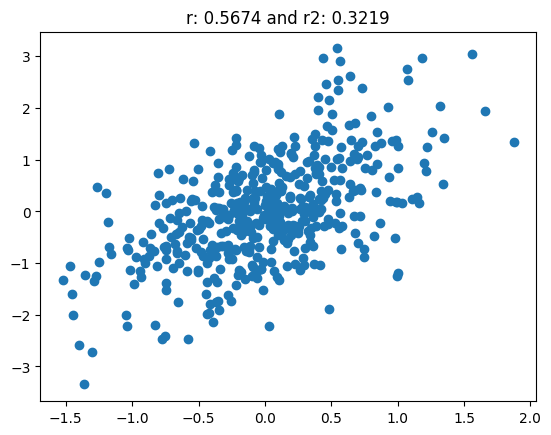

In [32]:
plt.scatter(predictions, y)
plt.title(f"r: {r:.4f} and r2: {r2:.4f}")

In [34]:
layer_ac_test = all_activations_test[layer_name]
test_x = flatten_layer(layer_ac_test)

# Apply PCA transformation from the train data
test_x = pca.transform(test_x)

In [39]:


test_y = test_data[:, channel, timepoint]

# Zscore the Y
test_y = zscore(test_y)

# NOTE: Make sure that this is ran only on testing and not testing...
#lin_reg = LinearRegression()
#lin_reg.fit(x, y)
#lin_reg = train_lin_regs[int(timepoint / downsampling_factor)]

test_predictions = lin_reg.predict(test_x)
test_r2 = lin_reg.score(test_x, test_y)
test_beta = lin_reg.coef_
test_r, _ = pearsonr(test_y, test_predictions)

Text(0.5, 1.0, 'TEST r: 0.4163 and r2: 0.1236')

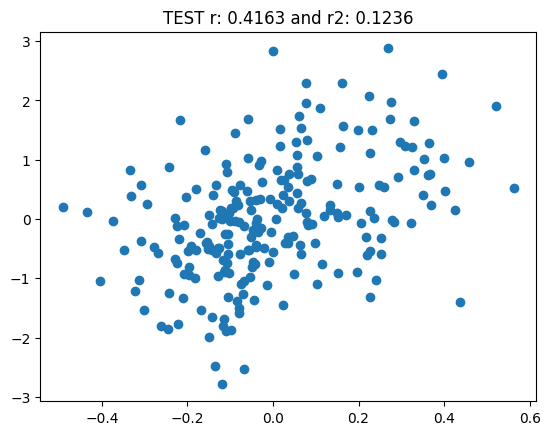

In [41]:
plt.scatter(test_predictions, test_y)
plt.title(f"TEST r: {test_r:.4f} and r2: {test_r2:.4f}")

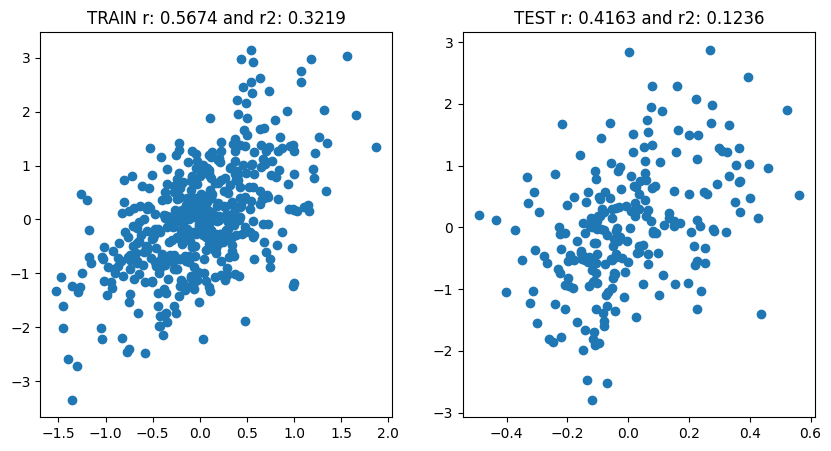

In [42]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(predictions, y)
ax[1].scatter(test_predictions, test_y)

ax[0].set_title(f"TRAIN r: {r:.4f} and r2: {r2:.4f}")
ax[1].set_title(f"TEST r: {test_r:.4f} and r2: {test_r2:.4f}")
plt.show()

In [52]:


# Loop over selected channels
for channel in selected_channel_indexes:

    #channel_name = channel_order[channel]
    # Make a new dir for the channel
    #channel_dir = os.path.join(layer_dir, channel_name)
    #os.makedirs(channel_dir, exist_ok=True)

    train_rs = []
    train_r2s = []
    train_betas = []
    train_lin_regs = []

    # Iterate over timepoints
    #for timepoint in range(n_timepoints):
    # Select every 4th point, AKA downsample to 256Hz
    for timepoint in range(0, n_timepoints, downsampling_factor):
        # The Y array for all images in one timepoint
        y = train_data[:, channel, timepoint]

        # Zscore the Y
        y = zscore(y)

        # NOTE: Make sure that this is ran only on training and not testing...
        lin_reg = LinearRegression()
        lin_reg.fit(x, y)

        predictions = lin_reg.predict(x)
        r2 = lin_reg.score(x, y)
        beta = lin_reg.coef_
        r, _ = pearsonr(y, predictions)

        train_rs.append(r)
        train_r2s.append(r2)
        train_betas.append(beta)
        train_lin_regs.append(lin_reg)

    # Save arrays in the channel directory
    #np.save(os.path.join(channel_dir, "train_rs.npy"), np.array(train_rs))
    #np.save(os.path.join(channel_dir, "train_r2s.npy"), np.array(train_r2s))
    #np.save(os.path.join(channel_dir, "train_betas.npy"), np.array(train_betas))
    #np.save(os.path.join(channel_dir, "train_lin_regs.npy"), np.array(train_lin_regs))

    # Plot and save
    plot_rs(train_r2s, f'$R^2$', f"TRAIN subject: {sub}, layer: {layer_name}", downsampling_factor)
    #plt.savefig(os.path.join(channel_dir, "train r2s"))
    plt.clf()
    plot_rs(train_rs, "Pearson`s  r", f"TRAIN subject: {sub}, layer: {layer_name}", downsampling_factor)
    #plt.savefig(os.path.join(channel_dir, "train rs"))
    plt.clf()


##################### TEST
# Get activations for the test dataset
layer_ac_test = all_activations_test[layer_name]
test_x = flatten_layer(layer_ac_test)

# Apply PCA transformation from the train data
test_x = pca.transform(test_x)

# Loop over selected channels
for channel in selected_channel_indexes:

    # channel_name = channel_order[channel]
    # Make a new dir for the channel
    #channel_dir = os.path.join(layer_dir, channel_name)
    #os.makedirs(channel_dir, exist_ok=True)

    test_rs = []
    test_r2s = []
    test_betas = []

    ######################## Iterate over timepoints
    #for timepoint in range(n_timepoints):
    # Select every 4th point, AKA downsample to 256Hz
    for timepoint in range(0, n_timepoints, downsampling_factor):
        # The Y array for all images in one timepoint
        y = test_data[:, channel, timepoint]

        # Zscore the Y
        y = zscore(y)

        # NOTE: Make sure that this is ran only on testing and not testing...
        #lin_reg = LinearRegression()
        #lin_reg.fit(x, y)
        lin_reg = train_lin_regs[int(timepoint / downsampling_factor)]

        predictions = lin_reg.predict(test_x)
        r2 = lin_reg.score(test_x, y)
        beta = lin_reg.coef_
        r, _ = pearsonr(y, predictions)

        # TODO: compare to the other r calculation...
        #corr = np.corrcoef(y, predictions)[0, 1]

        test_rs.append(r)
        test_r2s.append(r2)
        test_betas.append(beta)

    # Save arrays in the channel directory
    #np.save(os.path.join(channel_dir, "test_rs.npy"), np.array(test_rs))
    #np.save(os.path.join(channel_dir, "test_r2s.npy"), np.array(test_r2s))
    #np.save(os.path.join(channel_dir, "test_betas.npy"), np.array(test_betas))

    # Plot and save
    plot_rs(test_r2s, f'$R^2$', f"TEST subject: {sub}, layer: {layer_name}", downsampling_factor)
    #plt.savefig(os.path.join(channel_dir, "test r2s"))
    plt.clf()
    plot_rs(test_rs, "Pearson`s  r", f"TEST subject: {sub}, layer: {layer_name}", downsampling_factor)
    #plt.savefig(os.path.join(channel_dir, "test rs"))
    plt.clf()

<Figure size 640x480 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


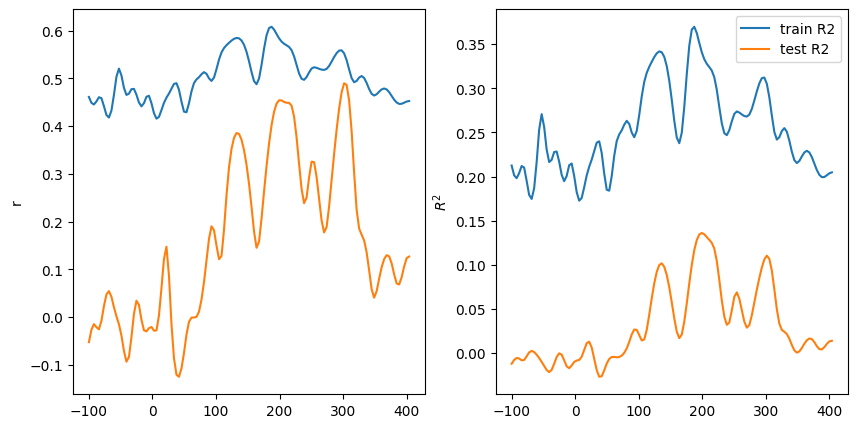

In [54]:
# Create time axis
# Length of the downsampled data
downsampled_num_points = len(train_rs)


time_range_seconds = original_num_points / original_sampling_rate  # Duration of original data in seconds
time_range_ms = time_range_seconds * 1000  # Convert duration to milliseconds
time_start_ms = -100  # Start time in milliseconds
time_end_ms = time_start_ms + time_range_ms  # End time in milliseconds

# Calculate original number of points
original_num_points = downsampled_num_points * downsampling_factor
time_axis = np.linspace(time_start_ms, time_end_ms, downsampled_num_points)

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(time_axis, train_rs, label="train r")
ax[0].plot(time_axis, test_rs, label="test r")
ax[0].set_ylabel('r')
plt.legend()


ax[1].plot(time_axis, train_r2s, label="train R2")
ax[1].plot(time_axis, test_r2s, label="test R2")
ax[1].set_ylabel(f'$R^2$')
#ax[0].set_title(f"TRAIN r: {r:.4f} and r2: {r2:.4f}")
#ax[1].set_title(f"TEST r: {test_r:.4f} and r2: {test_r2:.4f}")
plt.legend()
plt.show()

In [55]:
model

ResNetSimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra